In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:90% !important;}
div.cell.code_cell.rendered{width:100%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:16pt;}
div.text_cell_render.rendered_html{font-size:16pt;}
div.output {font-size:12pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:16pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:16pt;padding:5px;}
table.dataframe{font-size:16px;}
</style>
"""))

# red wine 품질 등급 예측
```
1. 데이터셋 확보 & 전처리
    독립변수와 타겟변수 분리 -> 독립변수 스케일조정(StandardScaler) -> 타겟변수원핫인코딩(get_dummies) ->
    훈련셋과 테스트셋분리(train_test_split)
2. 모델 구성(입력11, 출력?)
3. 모델 학습과정 설정
4, 모델 학습(callback 이용)
5. 모델 평가 - 그래프, 평가(테스트셋), 교차표
6. 모델 저장 / 사용
```

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, LeakyReLU
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
import matplotlib.pyplot as plt

# 1. 데이터셋 확보 & 전처리
    독립변수와 타겟변수 분리 -> 독립변수 스케일조정(StandardScaler) -> 타겟변수원핫인코딩(get_dummies) ->
    훈련셋과 테스트셋분리(train_test_split)

In [5]:
# 데이터 읽어오기
# np.loadtxt('data/winequality-red.csv', delimiter=';', skiprows=1)
redwine = pd.read_csv('data/winequality-red.csv', sep=';')
redwine
#고정 산도(fixed acidity)
#휘발성 산도(volatile acidity)
#구연산(citric acid)
#잔여 당분(residual sugar)
#염화물(chlorides)
#유리 아황산염(free sulfur dioxide)
#총 아황산염(total sulfur dioxide)
#밀도(density)
#pH
#황산염(sulphates)
#알코올(alcohol)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [6]:
# 타겟변수의 균형
redwine['quality'].value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

In [7]:
# 독립변수, 타겟변수 분리
X_redwine = redwine.iloc[:, :-1].values # to_numpy와 유사. numpy배열로
y_redwine = redwine.iloc[:, -1] # 3,4,5,6,7,8
X_redwine.shape, y_redwine.shape

((1599, 11), (1599,))

In [8]:
# 독립변수 X의 스케일 조정
scaler = StandardScaler()
scaler.fit(X_redwine)
scaled_X_redwine = scaler.transform(X_redwine)
# 다중분류를 위한 타겟변수의 원핫인코딩 -> numpy 배열로 변환
Y_redwine = pd.get_dummies(y_redwine).to_numpy()

In [9]:
# 독립변수:scaled_X_redwine & 타겟변수:Y_redwine
scaled_X_redwine.shape, Y_redwine.shape

((1599, 11), (1599, 6))

In [10]:
print('원데이터 :\t원핫인코딩')
np.column_stack([y_redwine[3:5], Y_redwine[3:5]])

원데이터 :	원핫인코딩


array([[6, 0, 0, 0, 1, 0, 0],
       [5, 0, 0, 1, 0, 0, 0]], dtype=int64)

In [11]:
# 훈련셋과 테스트셋 분리(층화추출)
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X_redwine,
                                                   Y_redwine,
                                                   train_size=0.7,
                                                   stratify=Y_redwine, # 층화
                                                   random_state=12)
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((1119, 11), (1119, 6), (480, 11), (480, 6))

In [15]:
np.c_[pd.Series(Y_redwine.argmax(axis=1)).value_counts(normalize=True),
pd.Series(Y_train.argmax(axis=1)).value_counts(normalize=True),
pd.Series(Y_test.argmax(axis=1)).value_counts(normalize=True)]

array([[0.42589118, 0.42627346, 0.425     ],
       [0.39899937, 0.39857015, 0.4       ],
       [0.12445278, 0.12421805, 0.125     ],
       [0.03314572, 0.03306524, 0.03333333],
       [0.01125704, 0.01161752, 0.01041667],
       [0.00625391, 0.00625559, 0.00625   ]])

# 2. 모델 구성(입력11,출력6)

In [17]:
model = Sequential()
model.add(Input(11))
model.add(Dense(units=50, activation='relu'))
model.add(Dense(units=50, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(30, 'relu'))
model.add(Dense(units=6, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 50)                600       
                                                                 
 dense_5 (Dense)             (None, 50)                2550      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_6 (Dense)             (None, 30)                1530      
                                                                 
 dense_7 (Dense)             (None, 6)                 186       
                                                                 
Total params: 4,866
Trainable params: 4,866
Non-trainable params: 0
_________________________________________________________________


# 3. 모델 학습과정 설정(다중분류에 맞는 설정)
# 4. 학습시키기(callbacks 이용)

In [19]:
%%time
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

class CustomHistory(Callback): # on_epoch_end()함수가 epoch수행후 자동 호출
    def __init__(self):
        self.epoch = 0
    def on_epoch_end(self, batch, logs={}):
        self.epoch += 1
        if (self.epoch%5 == 0) | (self.epoch==1):
            print('{}번째 loss:{:.4f}, acc:{:.4f}, val_loss:{:.4f}, val_acc:{:.4f}'\
                  .format(self.epoch,
                         logs.get('loss'),
                         logs.get('accuracy'),
                         logs.get('val_loss'),
                         logs.get('val_accuracy')
                )
            )
model_save_folder = './model/'
import os
if not os.path.exists(model_save_folder): # 폴더 없으면 폴더 생성
    os.mkdir(model_save_folder)
file = model_save_folder \
        + 'wine-{epoch:03d}-loss{val_loss:.4f}-acc{val_accuracy:.4f}.h5'
# 콜백 객체
customHistory = CustomHistory()
checkpoint = ModelCheckpoint(
                    filepath=file,
                    monitor='val_accuracy', # 모니터링 지표:loss, val_loss, accuracy
                    save_best_only=True,    # 모니터링 지표가 개선된 경우만 저장
                    mode = 'max',
                    verbose=0) # 로그 출력 여부
earlyStopping = EarlyStopping(monitor='val_loss', patience=20)
# 학습
hist = model.fit(X_train, Y_train, epochs=200, batch_size=200,
                validation_split=0.2, # 학습셋의 20%는 검증셋으로 
                verbose=0, # 로그출력 막음(콜백함수에서 출력)
                callbacks=[earlyStopping,
                          customHistory,
                          checkpoint])

1번째 loss:1.7250, acc:0.2737, val_loss:1.6616, val_acc:0.3304
5번째 loss:1.3188, acc:0.4905, val_loss:1.3440, val_acc:0.4464
10번째 loss:1.0560, acc:0.5799, val_loss:1.1460, val_acc:0.5580
15번째 loss:0.9756, acc:0.6056, val_loss:1.0930, val_acc:0.5446
20번째 loss:0.9397, acc:0.6067, val_loss:1.0700, val_acc:0.5670
25번째 loss:0.9167, acc:0.6335, val_loss:1.0600, val_acc:0.5670
30번째 loss:0.8984, acc:0.6212, val_loss:1.0511, val_acc:0.5536
35번째 loss:0.8680, acc:0.6391, val_loss:1.0405, val_acc:0.5625
40번째 loss:0.8512, acc:0.6402, val_loss:1.0332, val_acc:0.5714
45번째 loss:0.8394, acc:0.6480, val_loss:1.0259, val_acc:0.5670
50번째 loss:0.8329, acc:0.6536, val_loss:1.0207, val_acc:0.5759
55번째 loss:0.8132, acc:0.6547, val_loss:1.0124, val_acc:0.5804
60번째 loss:0.8028, acc:0.6581, val_loss:1.0107, val_acc:0.5982
65번째 loss:0.7663, acc:0.6872, val_loss:1.0159, val_acc:0.5893
70번째 loss:0.7641, acc:0.6827, val_loss:1.0163, val_acc:0.5848
75번째 loss:0.7570, acc:0.6860, val_loss:1.0053, val_acc:0.6071
80번째 loss:

# 5. 모델평가

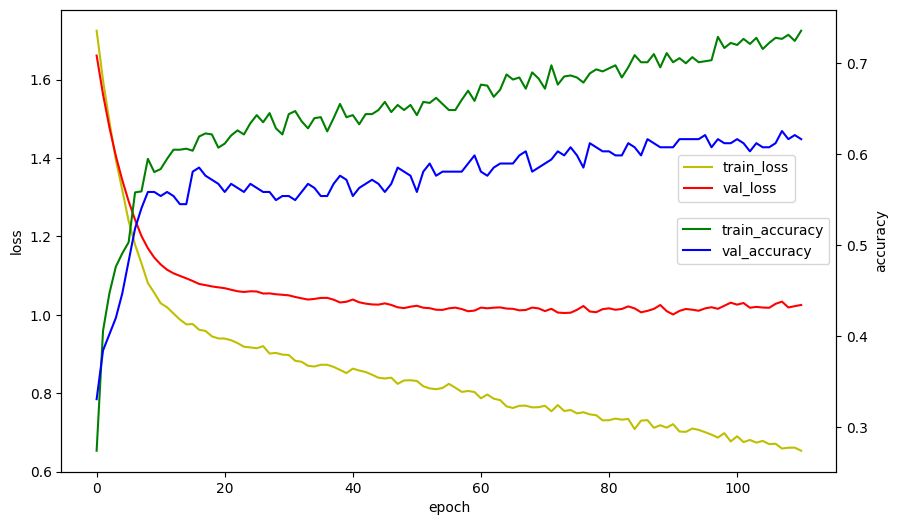

In [20]:
fig, loss_ax = plt.subplots(figsize=(10,6))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val_loss')
acc_ax = loss_ax.twinx() # loss_ax와 x축을 공유하는 acc_ax 생성
acc_ax.plot(hist.history['accuracy'], 'g', label='train_accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val_accuracy')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(bbox_to_anchor=(0.955, 0.7))
acc_ax.legend(loc='center right')
plt.show()

In [21]:
# 모델 평가
loss_and_acc =model.evaluate(X_test, Y_test, batch_size=100, verbose=0)
print(f'loss:{loss_and_acc[0]:.4f}, accuracy:{loss_and_acc[1]:.4f}')

loss:1.0047, accuracy:0.6229


In [25]:
# 교차표 (실제값과 예측값을 1차원 데이터로)
# real = Y_test.argmax(axis=1)
real = np.argmax(Y_test, axis=1)
pred = model.predict(X_test).argmax(axis=1)
pd.crosstab(real, pred, rownames=['real'], colnames=['predict'])

15/15 [==============================] - 0s 995us/step


predict,2,3,4
real,,,
0,3,0,0
1,8,7,1
2,143,59,2
3,42,124,26
4,2,26,32
5,0,1,4


# 6. 모델사용

In [26]:
X_redwine[0]

array([ 7.4   ,  0.7   ,  0.    ,  1.9   ,  0.076 , 11.    , 34.    ,
        0.9978,  3.51  ,  0.56  ,  9.4   ])

In [27]:
input_data = [7.4, 0.7, 0, 1.9, 0.076, 11.0, 34.0, 0.9978, 3.51, 0.56, 9.4]
scaled_data = scaler.transform([input_data])
model.predict(scaled_data).argmax(axis=1)+3

1/1 [==============================] - 0s 50ms/step


array([5], dtype=int64)